In [156]:
import dolfin
import mshr
import ufl
import numpy as np
import matplotlib.pyplot as plt
dolfin.parameters["form_compiler"]["cpp_optimize"] = True
dolfin.parameters["form_compiler"]["representation"] = "uflacs"
plt.style.use('seaborn-notebook')
%matplotlib inline

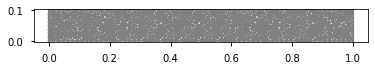

In [157]:
Lx, Ly = 1., .1
nx = 50
p0 = dolfin.Point(0,0)
p1 = dolfin.Point(Lx,Ly)
geom = mshr.Rectangle(p0,p1)
mesh = mshr.generate_mesh(geom,nx)

# Mark boundary subdomains
left = dolfin.CompiledSubDomain("near(x[0],0) && on_boundary")
right = dolfin.CompiledSubDomain("near(x[0],Lx) && on_boundary",Lx=Lx)
bottom = dolfin.CompiledSubDomain("near(x[1],0) && on_boundary")
top = dolfin.CompiledSubDomain("near(x[1],Ly) && on_boundary",Ly=Ly)

# Mark facets for Neumann BCs
boundary_indices = {'left': 1,
                    'right': 2,
                    'top': 3,
                    'bottom': 4}
boundary_markers = dolfin.MeshFunction("size_t", mesh, dim=1, value=0)
left.mark(boundary_markers, boundary_indices["left"])
right.mark(boundary_markers, boundary_indices["right"])
top.mark(boundary_markers, boundary_indices["top"])
bottom.mark(boundary_markers, boundary_indices["bottom"])

# Redefine element of area to include information about the markers
ds = dolfin.ds(domain=mesh, subdomain_data=boundary_markers)
dx = dolfin.dx(domain=mesh)
dolfin.plot(mesh)

In [158]:
V_element = dolfin.VectorElement('CG', ufl.triangle, degree=1) 
V = dolfin.FunctionSpace(mesh, V_element)
u = dolfin.Function(V)
v = dolfin.TestFunction(V)
w = dolfin.TrialFunction(V)

In [159]:
# Kinematics 
Id = ufl.Identity(2)    # Identity tensor
F = ufl.variable(Id + ufl.grad(u))  
C = F.T*F                   
Ic = ufl.tr(C)
J  = ufl.det(F)
E = 1/2*(C-Id)
# Stored strain energy density (compressible neo-Hookean model)
# Elasticity parameters (plane-stress)
Y, nu = 1.e3, 0.3
mu, lmbda = dolfin.Constant(Y/(2*(1 + nu))), dolfin.Constant(Y*nu/((1 + nu)*(1 - 2*nu)))
lmbda = 2*lmbda*mu/(lmbda + 2*mu) 
psi = lmbda*ufl.tr(E)**2/2+mu*ufl.inner(E,E)

In [160]:
sig_cr= Y*(np.pi*Ly/Lx)**2/48
print(sig_cr)

2.0561675835602826


In [161]:
T = dolfin.Expression(("-t*sig_cr","0"), t=1., sig_cr=sig_cr, degree =0)
potential_energy = psi*dx-ufl.dot(T,u)*ds(boundary_indices['right'])

In [162]:
bcs = [dolfin.DirichletBC(V, (0.,0.), left)]

In [163]:
dE = ufl.derivative(potential_energy, u, v)
ddE = ufl.derivative(dE, u, w)

In [164]:
#2.1: u0=0 and S0=lambda
problem = dolfin.NonlinearVariationalProblem(dE, u, bcs=bcs, J=ddE)
solver = dolfin.NonlinearVariationalSolver(problem)
dolfin.info(solver.parameters, True)

In [165]:
eps_v = dolfin.sym(dolfin.grad(v)) 
eps_w = dolfin.sym(dolfin.grad(w))
sig_v = lmbda*dolfin.tr(eps_v)*Id+2*mu*eps_v 

In [166]:
a_e = dolfin.inner(sig_v, eps_w)*dx
a_g = -dolfin.Constant(sig_cr)*dolfin.inner(v.dx(0), w.dx(0))*dx

In [167]:
a_H = dolfin.inner(v, w)*dx

In [168]:
K_e = dolfin.assemble(a_e)
K_g = dolfin.assemble(a_g)

---- setting additional slepc options -----
     eps_max_it : 100
-------------------------------------------
Solution method: krylovschur, stopping condition: tol=1e-08, maxit=100
Number of converged/requested eigenvalues with 3 iterations  : 10/10


array([-0.98034852+0.j, -0.1159902 +0.j, -0.04664769+0.j, -0.0274082 +0.j,
       -0.01937627+0.j, -0.01522145+0.j, -0.0127729 +0.j, -0.01119687+0.j,
       -0.01010493+0.j, -0.00932228+0.j])

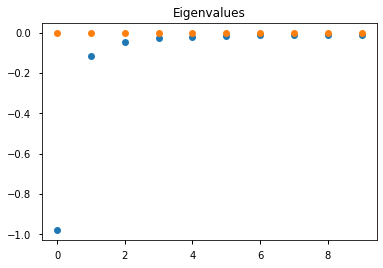

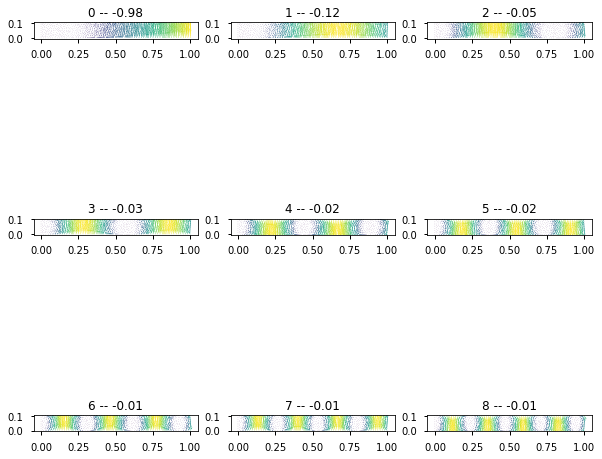

In [169]:
from slepc_eigensolver import EigenSolver
from slepc4py import SLEPc
slepc_solver = SLEPc.EPS()
slepc_solver.create()
slepc_solver.setWhichEigenpairs(slepc_solver.Which.LARGEST_MAGNITUDE)
slepc_solver.setFromOptions()
eig_solver = EigenSolver(a_g, a_e, u, bcs=bcs, slepc_eigensolver=slepc_solver)
ncv, it = eig_solver.solve(10)

eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(10)
eig_solver.save_eigenvectors(ncv)

#plots
plt.figure()
plt.plot(eigenvalues.real,'o')
plt.plot(eigenvalues.imag,'o')
plt.title("Eigenvalues")

figure = plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    dolfin.plot(eigenvectors_real[i])
    plt.title("{:d} -- {:2.2f}".format(i,eigenvalues[i].real))
plt.gcf().subplots_adjust(hspace= .3)

eigenvalues

---- setting additional slepc options -----
     eps_max_it : 100
-------------------------------------------
Solution method: krylovschur, stopping condition: tol=1e-08, maxit=100
Number of converged/requested eigenvalues with 6 iterations  : 11/10


array([-0.02802916+0.j, -0.02526763+0.j,  0.02448185+0.j,  0.02377199+0.j,
       -0.0236799 +0.j, -0.02287257+0.j,  0.02269171+0.j, -0.02200042+0.j,
        0.02184584+0.j, -0.02158475+0.j])

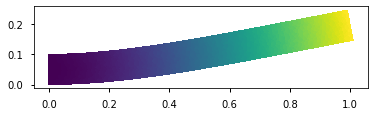

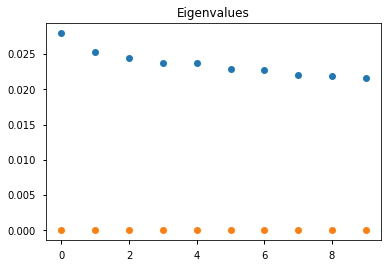

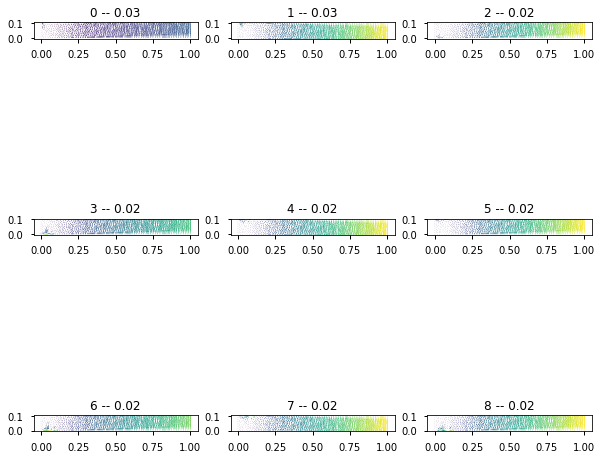

In [170]:
#2.2: u0=0 and the Cauchy stress
atol = 1e-8*3.125e-3

def strain_displacement(u):
    return dolfin.sym(dolfin.grad(u))

def stress_strain(eps):
    return lmbda*dolfin.tr(eps)*Id+2*mu*eps

bilinear_form = dolfin.inner(stress_strain(strain_displacement(w)),
                             strain_displacement(v))*dolfin.dx
#traction = dolfin.Expression(('x[0] < x_right ? 0.0 : -12.*M/d/d/d*x[1]', '0.0'),
#                             x_right=Lx-atol, M=1.0, d=Ly, degree=2)
linear_form = dolfin.dot(T, v)*dolfin.ds


g = 1.
body_forces = dolfin.Constant((0., g))
M_max = 0.5*Lx**2*Ly*g
linear_form = dolfin.dot(body_forces, v)*dolfin.dx

problem = dolfin.LinearVariationalProblem(bilinear_form, linear_form, u, bcs)

solver = dolfin.LinearVariationalSolver(problem)
solver.solve()

dolfin.plot(u, mode='displacement')

sig = stress_strain(strain_displacement(u))
V_sig = dolfin.FunctionSpace(mesh, dolfin.FiniteElement('DG', cell=mesh.ufl_cell(), degree=1))


dolfin.plot(sig)
sig_v = lmbda*dolfin.tr(dolfin.grad(v))*Id+2*mu*dolfin.grad(v)


a_e = dolfin.inner(sig_v, eps_w)*dx
a_g = dolfin.inner(sig,dolfin.dot(dolfin.sym(dolfin.grad(v)),dolfin.sym(dolfin.grad(w))))*dx

a_H = dolfin.inner(v, w)*dx

K_e = dolfin.assemble(a_e)
K_g = dolfin.assemble(a_g)

slepc_solver = SLEPc.EPS()
slepc_solver.create()
slepc_solver.setWhichEigenpairs(slepc_solver.Which.LARGEST_MAGNITUDE)
slepc_solver.setFromOptions()
eig_solver = EigenSolver(a_g, a_e, u, bcs=bcs, slepc_eigensolver=slepc_solver)
ncv, it = eig_solver.solve(10)

eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(10)
eig_solver.save_eigenvectors(ncv)

#plots
plt.figure()
plt.plot(np.abs(eigenvalues.real),'o')
plt.plot(eigenvalues.imag,'o')
plt.title("Eigenvalues")

figure = plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    dolfin.plot(eigenvectors_real[i])
    plt.title("{:d} -- {:2.2f}".format(i,np.abs(eigenvalues[i].real)))
plt.gcf().subplots_adjust(hspace= .3)

eigenvalues

In [171]:
#2.3: solution of the the nonlinear elasticity problem for the current loading
# First and second Piola-Kirchhoff tensors
P = ufl.diff(psi,F)
S = ufl.inv(F)*P

i0, i1, i2, i3, i4 = ufl.indices(5)
tmp = ufl.diff(S,F)
CE = ufl.as_tensor(ufl.inv(F)[i0,i4]*tmp[i4,i1,i2,i3], (i0,i1,i2,i3))

tmp1 = F.T* ufl.grad(u)
tmp2 = F.T* ufl.grad(v)

a_k = CE[i0,i1,i2,i3]*tmp1[i0,i1]*tmp2[i2,i3]*dx
a_g = S[i0,i1]*u[i4].dx(i0)*v[i4].dx(i1)*dx

a_H = dolfin.inner(v, w)*dx

K_k = dolfin.assemble(a_k)
K_g = dolfin.assemble(a_g)

from slepc_eigensolver import EigenSolver
from slepc4py import SLEPc
slepc_solver = SLEPc.EPS()
slepc_solver.create()
slepc_solver.setWhichEigenpairs(slepc_solver.Which.LARGEST_MAGNITUDE)
slepc_solver.setFromOptions()
eig_solver = EigenSolver(a_g, a_k, u, bcs=bcs, slepc_eigensolver=slepc_solver)
ncv, it = eig_solver.solve(10)


#eig_solver = EigenSolver(a_k, a_g, u, bcs=bcs)
#neig = 10
#ncv, it = eig_solver.solve(neig)
#eigenvalues, [eigenvectors_real, eigenvectors_im] = eig_solver.get_eigenpairs(neig)
#eig_solver.save_eigenvectors(ncv)

#plots
plt.figure()
plt.plot(eigenvalues.real,'o')
plt.plot(eigenvalues.imag,'o')
plt.title("Eigenvalues")

figure = plt.figure(figsize = (10, 10))
for i in range(9):
    plt.subplot(3,3,i+1)
    dolfin.plot(eigenvectors_real[i])
    plt.title("{:d} -- {:2.2f}".format(i,eigenvalues[i].real))
plt.gcf().subplots_adjust(hspace= .3)

eigenvalues

AttributeError: 'dolfin.cpp.la.PETScVector' object has no attribute 'mat'